# <p style="background-color:#5A0E24;font-family:newtimeroman;color:#FFF9ED;font-size:90%;text-align:center;border-radius:10px; border: 2px solidrgb(98, 0, 255); padding: 10px;"> Brain Cancer Classification</p>


## Introduction

Brain tumors are among the most serious and life-threatening neurological conditions, where accurate and early diagnosis plays a crucial role in determining appropriate treatment strategies and improving patient survival rates. Magnetic Resonance Imaging (MRI) is widely used for brain examination due to its high-resolution visualization of soft tissues and its ability to reveal structural abnormalities without invasive procedures.

Despite its effectiveness, the interpretation of brain MRI scans remains a challenging and time-consuming task that relies heavily on the expertise of radiologists. Variations in tumor appearance, location, size, and intensity can lead to diagnostic uncertainty, especially in complex or early-stage cases. As medical imaging data continues to grow rapidly, there is an increasing need for automated and reliable diagnostic support systems.

This project explores the use of artificial intelligence to assist in the classification of brain tumors from MRI images. By learning patterns directly from imaging data, the proposed system aims to distinguish between different types of brain tumors as well as healthy brain scans. Such an automated approach has the potential to support medical professionals by improving diagnostic consistency, reducing workload, and providing faster preliminary assessments.


## Brain Tumor Classes Description

| Class Name        | Description |
|------------------|-------------|
| Glioma           | A type of tumor that originates from glial cells in the brain or spinal cord. Gliomas are often malignant and can vary significantly in size, shape, and location. |
| Meningioma       | A usually slow-growing tumor that develops from the meninges, the protective membranes surrounding the brain and spinal cord. Meningiomas are often benign but may cause symptoms due to pressure on brain tissues. |
| Pituitary Tumor  | A tumor occurring in the pituitary gland, which can affect hormone production and lead to various endocrine disorders. These tumors may be benign or malignant. |
| No Tumor         | MRI scans of healthy brains without any detectable tumor or abnormal tissue growth. |


#
<a id='1'></a>

<p style="
    background: linear-gradient(to right, #5C4033, #8B5A2B); 
    font-family: 'Times New Roman', serif; 
    color: #F5DEB3; 
    font-size: 30px; 
    text-align: center; 
    border-radius: 12px; 
    padding: 12px; 
    border: 3px solid #D2B48C;
    box-shadow: 2px 2px 10px rgba(210, 180, 140, 0.5);
    font-weight: bold;
    letter-spacing: 1px;
">
    IMPORTING LIBRARIES
</p>


In [19]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

#
<a id='1'></a>

<p style="
    background: linear-gradient(to right, #5C4033, #8B5A2B); 
    font-family: 'Times New Roman', serif; 
    color: #F5DEB3; 
    font-size: 30px; 
    text-align: center; 
    border-radius: 12px; 
    padding: 12px; 
    border: 3px solid #D2B48C;
    box-shadow: 2px 2px 10px rgba(210, 180, 140, 0.5);
    font-weight: bold;
    letter-spacing: 1px;
">
    READING DATA
</p>


In [ ]:
BASE_DIR = r"C:\Users\moham\Downloads\Amit_Course\Graduation_Project\Brain_Cancer_Classification\Brain_Data"

train_dir = os.path.join(BASE_DIR, "Training")
test_dir  = os.path.join(BASE_DIR, "Testing")

print(os.listdir(train_dir))

['glioma', 'meningioma', 'notumor', 'pituitary']


## Plotting Samples From Classes

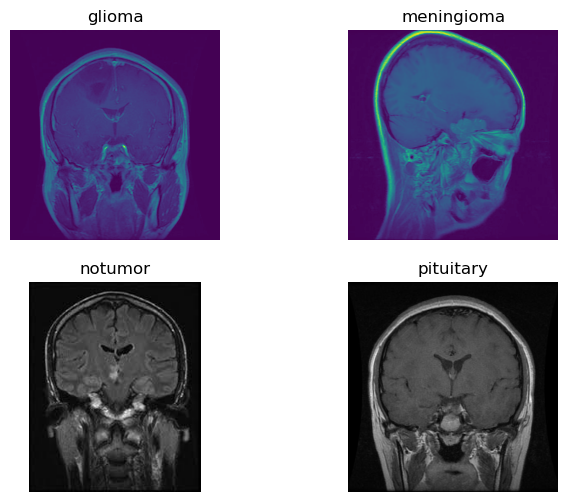

In [ ]:
classes = os.listdir(train_dir)
plt.figure(figsize=(8,6))

for i, cls in enumerate(classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img_path = os.path.join(train_dir, cls, img_name)
    img = Image.open(img_path)

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


## Reading Train & Validation Data With Augmentation

In [9]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2,
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


## Reading Test Data & Preprocessing

In [ ]:
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 1311 images belonging to 4 classes.


#
<a id='1'></a>

<p style="
    background: linear-gradient(to right, #5C4033, #8B5A2B); 
    font-family: 'Times New Roman', serif; 
    color: #F5DEB3; 
    font-size: 30px; 
    text-align: center; 
    border-radius: 12px; 
    padding: 12px; 
    border: 3px solid #D2B48C;
    box-shadow: 2px 2px 10px rgba(210, 180, 140, 0.5);
    font-weight: bold;
    letter-spacing: 1px;
">
    EDA (Exploratory Data Analysis)
</p>


## Counting Classes images

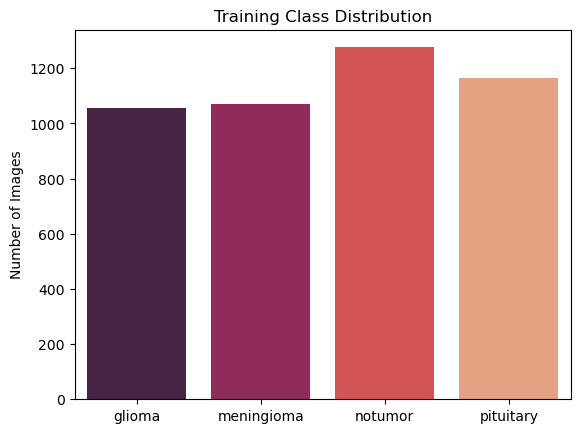

In [47]:
class_counts = Counter(train_data.classes)

sns.barplot(x= class_counts.keys(),y= class_counts.values(), palette="rocket")
plt.xticks(range(len(class_counts)), train_data.class_indices.keys())
plt.title("Training Class Distribution")
plt.ylabel("Number of Images")
plt.show()

## Samples with CLAHE

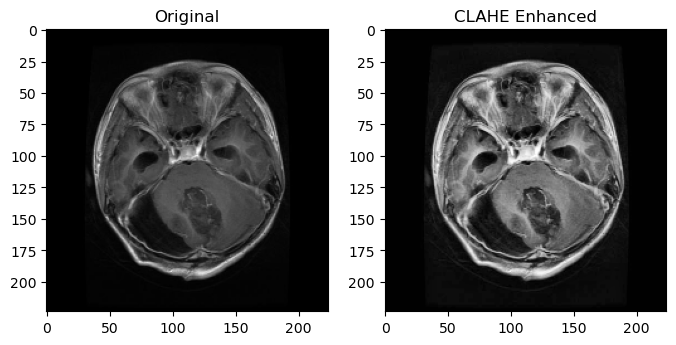

In [ ]:
img_path = test_data.filepaths[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224,224))

img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0)
img_clahe = clahe.apply(img_gray)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap="gray")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(img_clahe, cmap="gray")
plt.title("CLAHE Enhanced")
plt.show()


## Pixel Intensities in 4 Classes

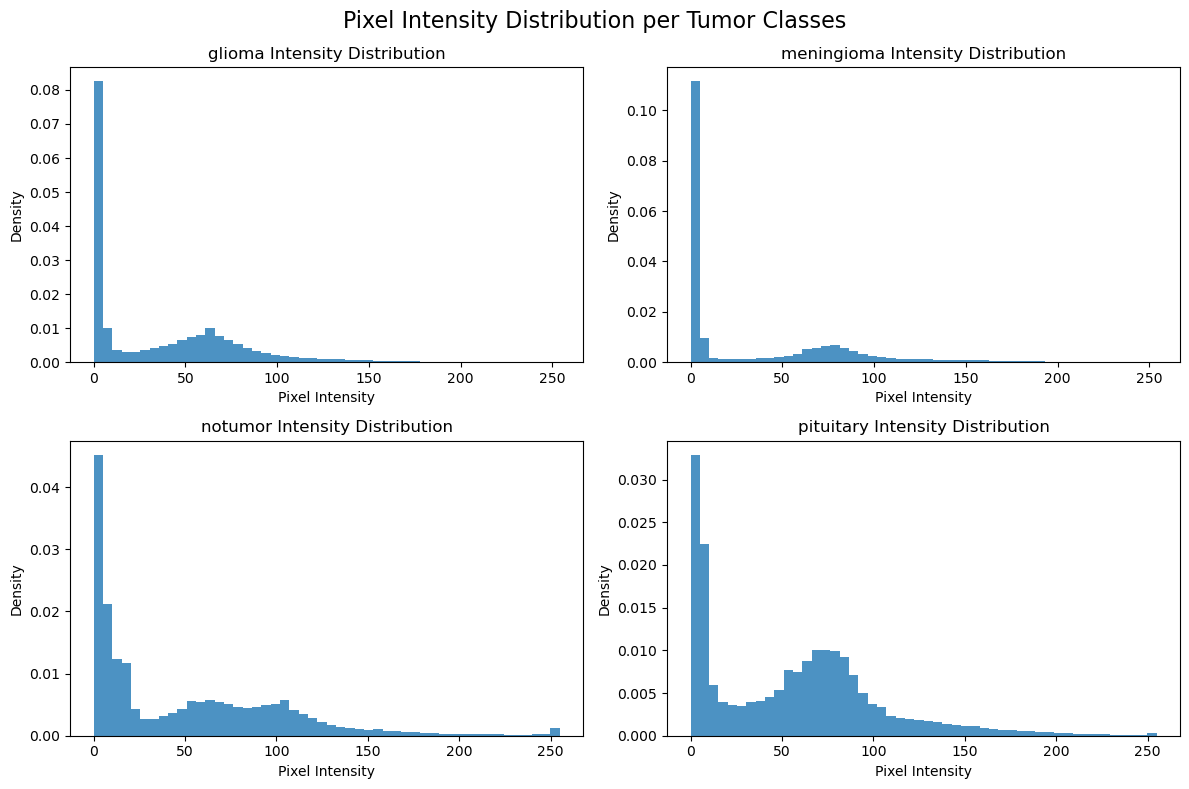

In [ ]:
classes = list(class_pixels.keys())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, cls in enumerate(classes):
    axes[i].hist(
        class_pixels[cls],
        bins=50,
        density=True,
        alpha=0.8
    )
    axes[i].set_title(f"{cls} Intensity Distribution")
    axes[i].set_xlabel("Pixel Intensity")
    axes[i].set_ylabel("Density")

plt.suptitle("Pixel Intensity Distribution per Tumor Classes", fontsize=16)
plt.tight_layout()
plt.show()


## Average Pixel Intensities 

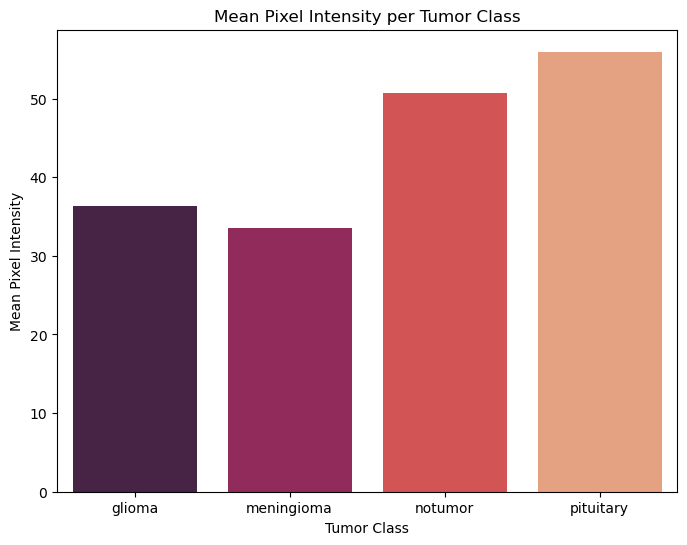

In [45]:
classes = list(class_pixels.keys())
mean_intensities = [class_pixels[cls].mean() for cls in classes]

plt.figure(figsize=(8,6))
sns.barplot(x= classes,y= mean_intensities, palette="rocket")

plt.title("Mean Pixel Intensity per Tumor Class")
plt.xlabel("Tumor Class")
plt.ylabel("Mean Pixel Intensity")
plt.show()

#
<a id='1'></a>

<p style="
    background: linear-gradient(to right, #5C4033, #8B5A2B); 
    font-family: 'Times New Roman', serif; 
    color: #F5DEB3; 
    font-size: 30px; 
    text-align: center; 
    border-radius: 12px; 
    padding: 12px; 
    border: 3px solid #D2B48C;
    box-shadow: 2px 2px 10px rgba(210, 180, 140, 0.5);
    font-weight: bold;
    letter-spacing: 1px;
">
    MODEL TRAINING
</p>


## Training with non Trainable Layers

In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## Adding CallBacks

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

## First Train with all Freezed Layers

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    batch_size=32,
    callbacks=[callbacks],
)

## Continue with Unfreezing some Layers

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    batch_size=32,
    callbacks=[callbacks],
)

#
<a id='1'></a>

<p style="
    background: linear-gradient(to right, #5C4033, #8B5A2B); 
    font-family: 'Times New Roman', serif; 
    color: #F5DEB3; 
    font-size: 30px; 
    text-align: center; 
    border-radius: 12px; 
    padding: 12px; 
    border: 3px solid #D2B48C;
    box-shadow: 2px 2px 10px rgba(210, 180, 140, 0.5);
    font-weight: bold;
    letter-spacing: 1px;
">
    MODEL EVALUATION
</p>


## Loading Model

In [58]:
model = tf.keras.models.load_model("best_model.h5")

## Predict with Classification report

In [59]:
y_pred = model.predict(test_data)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(
    test_data.classes,
    y_pred_classes,
    target_names=test_data.class_indices.keys()
))

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 638ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.95      0.91      0.93       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.94      1.00      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



## Confusion Matrix

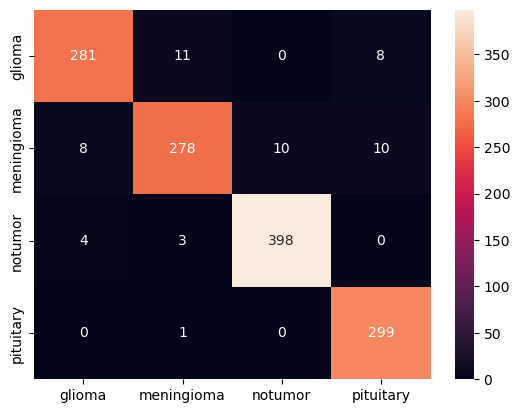

In [147]:
cm = confusion_matrix(test_data.classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys(),)
plt.show()


## ROC-Score

In [61]:
y_true = tf.keras.utils.to_categorical(test_data.classes, 4)
auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
print("ROC-AUC:", auc)

ROC-AUC: 0.9970976887426378


## Grad_CAM

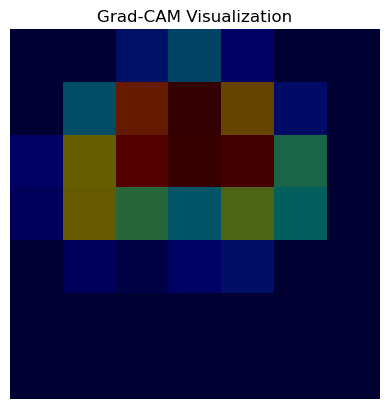

In [148]:
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)

    return heatmap

img, _ = test_data[0]
heatmap = grad_cam(model, img[:1], "top_conv")

plt.imshow(img[0])
plt.imshow(heatmap, cmap="jet", alpha=0.4)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

## Visualize Grad_CAM With Normal Image

In [149]:
idx = np.random.randint(0, len(test_data))

img = test_data[idx][0][:1]          

heatmap = grad_cam(model, img_input, 
    layer_name="top_conv"
)

img_display = (img * 255).astype(np.uint8)
heatmap_resized = cv2.resize(heatmap, (224, 224))

In [150]:
heatmap = grad_cam(model, img_array, layer_name="top_conv")
heatmap = np.maximum(heatmap, 0)
heatmap /= (np.max(heatmap) + 1e-8)

heatmap_resized = cv2.resize(heatmap, (224,224))

heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(img_resized, 0.6, 
    heatmap_color,
    0.4, 0
)

In [151]:
img_display = img_display[0]
img_display = np.uint8(img_display)

heatmap_resized = cv2.resize(heatmap_resized, (224, 224))
heatmap_uint8 = np.uint8(255 * heatmap_resized)

heatmap_color = cv2.applyColorMap(
    heatmap_uint8,
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(
    img_display, 0.6,
    heatmap_color, 0.4,
    0
)

In [152]:
h, w = heatmap_resized.shape
y, x = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)

size = int(0.15 * min(h, w))

x1, y1 = max(0, x - size), max(0, y - size)
x2, y2 = min(w, x + size), min(h, y + size)

zoom = img_display[y1:y2, x1:x2]

if zoom.size == 0:
    zoom = img_display.copy()

y_pred = model.predict(img_input)
conf = np.max(y_pred)
pred_class = list(test_data.class_indices.keys())[np.argmax(y_pred)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


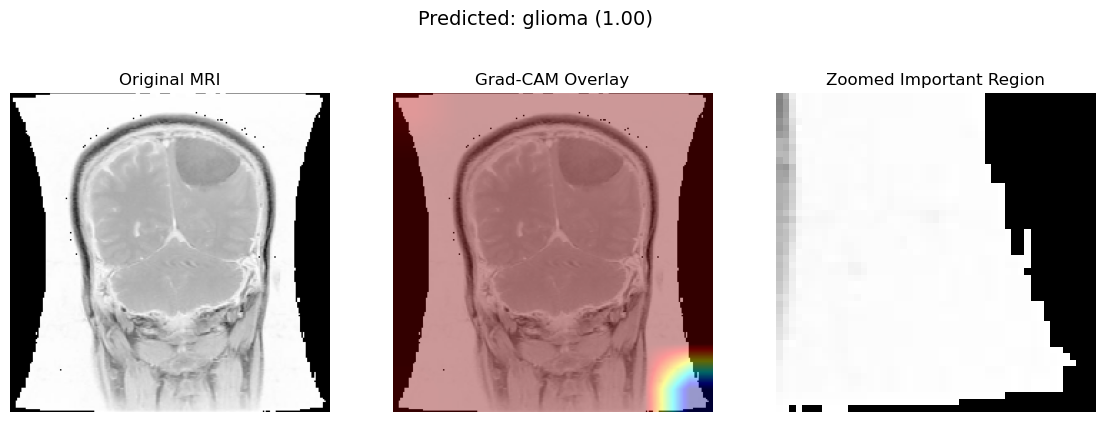

In [153]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_display)
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(zoom)
plt.title("Zoomed Important Region")
plt.axis("off")

plt.suptitle(f"Predicted: {pred_class} ({conf:.2f})", fontsize=14)
plt.show()
